In [38]:
import speech_recognition as sr
import librosa
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa.display
import numpy as np

### Load the .wav audio file

In [39]:
filename = 'filler'
wave, fs = librosa.load(filename+'.wav')

### Visualize the amplitude in time domain

Frequency 22050
Duration 8.95201814058957 s


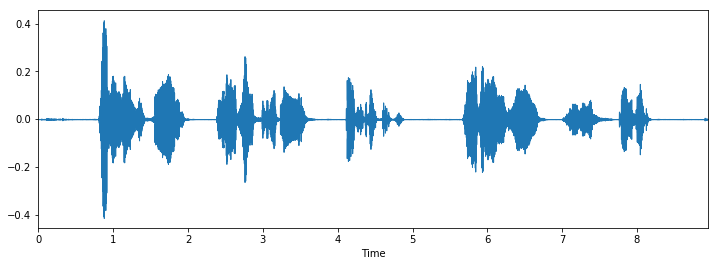

In [40]:
print("Frequency",fs)
print("Duration",len(wave)/fs,"s")

plt.figure(figsize=(12, 4))
librosa.display.waveplot(wave, sr=fs)

In [41]:
ipd.Audio(wave, rate=22000)

### End-point detection (VAD) 

#### Detecting the start point and end point of voice activity

#### Source: https://www.kaggle.com/jerrypeng/dsp-tutorial-3-demos-for-speech-processing

### 1. Calculate RMS and Zero Crossing Rate

In [42]:
frame_len = int(60 * fs /1000) # 20ms
frame_shift = int(10 * fs /1000) # 10ms
# calculate RMS
rms = librosa.feature.rmse(wave, frame_length=frame_len, hop_length=frame_shift)
rms = rms[0]
rms = librosa.util.normalize(rms, axis=0)

# calculate zero-crossing rate
zrc = librosa.feature.zero_crossing_rate(wave, frame_length=frame_len, hop_length=frame_shift, threshold=0)
zrc = zrc[0]
#zrc = librosa.util.normalize(zrc, axis=0)

### 2. Visualize the amplitude with RMS Energy and Zero Crossing Rate

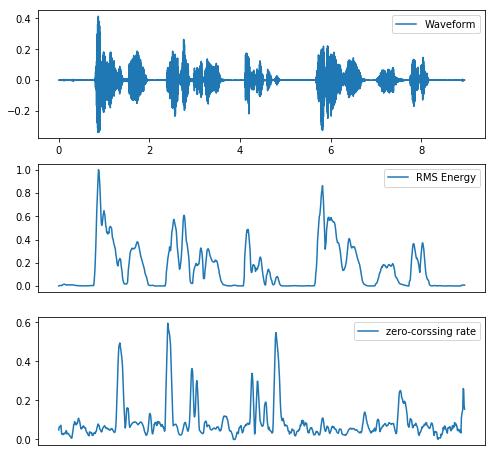

In [43]:
plt.figure(figsize=(8, 8))
plt.subplot(3, 1, 1)
t = np.linspace(0, len(wave)/fs, len(wave))
plt.plot(t, wave, label='Waveform')
plt.legend(loc='best')

plt.subplot(3, 1, 2)
plt.plot(rms.T, label='RMS Energy')
plt.xticks([])
plt.legend(loc='best')

plt.subplot(3, 1, 3)
plt.plot(zrc.T, label='zero-corssing rate')
plt.xticks([])
plt.legend(loc='best')
plt.show()

### 3. Set threshold of speech and silence

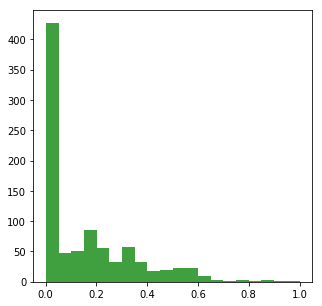

In [44]:
plt.figure(figsize=(5, 5))
n, bins, patches = plt.hist(rms.T, 20, facecolor='g', alpha=0.75)

Based on the histogram above, we can set threshold of RMS at 0.1 and 0. 6 for zrc.

In [45]:
frame_idxs = np.where( (rms > 0.1) | (zrc > 0.5) )[0]

### 4. Based on the frame indices, get start and end points of frames

In [46]:
def getboundaries(frame_idxs):
    #get the first frame index
    start_idxs = [frame_idxs[0]]
    end_idxs = []

    #get the length of list of frame indices
    shapeofidxs = np.shape(frame_idxs)

    #for each index in the list 
    for i in range(shapeofidxs[0]-1):
        #if the next index is in a different frame (difference > 1)
        if (frame_idxs[i + 1] - frame_idxs[i]) != 1:
            #i is an end index 
            end_idxs.append(frame_idxs[i])
            #i+1 is a start index
            start_idxs.append(frame_idxs[i+1])
            
    #last index of the list will be an end index
    end_idxs.append(frame_idxs[-1])
    
    # del the last boundaries if it is both start point and end point.
    if end_idxs[-1] == start_idxs[-1]:
        end_idxs.pop()
        start_idxs.pop()
    assert len(start_idxs) == len(end_idxs), 'Error! Num of start_idxs doesnt match Num of end_idxs.'
    
    #convert into np.array
    start_idxs = np.array(start_idxs)
    end_idxs = np.array(end_idxs)
    
    #from index, convert to time 
    start_t = start_idxs * frame_shift / fs
    end_t = end_idxs * frame_shift / fs
    return start_t, end_t

In [47]:
start_t, end_t = getboundaries(frame_idxs)
print("Number of frames: ", len(start_t))

Number of frames:  11


### 5. Visualize the wave with frames (Red: start, Green: end)

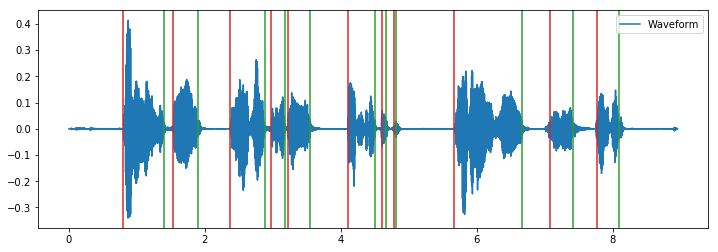

In [48]:
plt.figure(figsize=(12, 4))
t = np.linspace(0, len(wave)/fs, len(wave))
plt.plot(t, wave, label='Waveform')
for s, e in zip(start_t, end_t):
    plt.axvline(x=s, color='#d62728') # red vertical line
    plt.axvline(x=e, color='#2ca02c') # green vertical line
plt.legend(loc='best')
plt.show()

### 6. Reformate the time frame limits computed by the algorithms (to be consistence with the wave's time domain)

In [49]:
#Reformat the time frame limits computed by the algorithms 

#Cut down to 10 decimal place
start_t = [(float("{0:.10f}".format(x))) for x in start_t]
end_t = [(float("{0:.10f}".format(i))) for i in end_t]

#Compare with the real timeline of the file, take the time period nearest to 4 decimal place 
s = 0
e = 0
#Retrieve the time frame correspond to the real time graph
new_start = []
new_end = []
time = np.linspace(0, len(wave)/fs, len(wave))
time = [(float("{0:.10f}".format(a))) for a in time]
for t in time: 
    if s < len(start_t) and abs(start_t[s]-t) < 0.0001:
        print("start","algo: ", start_t[s],"    " ,"original from graph: ", t)
        new_start.append(t)
        s = s + 1
    elif e < len(end_t) and abs(end_t[e]-t) < 0.0001:
        print(" end","algo: ", end_t[e], "    ","original from graph: ", t)
        new_end.append(t)
        e = e + 1

start algo:  0.798185941      original from graph:  0.7980992813
 end algo:  1.3968253968      original from graph:  1.3967417699
start algo:  1.5365079365      original from graph:  1.5364250172
 end algo:  1.9056689342      original from graph:  1.9055878851
start algo:  2.3746031746      original from graph:  2.3745245011
 end algo:  2.883446712      original from graph:  2.8833706164
start algo:  2.9732426304      original from graph:  2.9731669897
 end algo:  3.1827664399      original from graph:  3.1826918607
start algo:  3.222675737      original from graph:  3.2226013599
 end algo:  3.5419501134      original from graph:  3.5418773538
start algo:  4.1006802721      original from graph:  4.1006103431
 end algo:  4.4997732426      original from graph:  4.4997053355
start algo:  4.5995464853      original from graph:  4.5994790836
 end algo:  4.6594104308      original from graph:  4.6593433324
start algo:  4.779138322      original from graph:  4.7790718301
 end algo:  4.8090702

### 7. Redraw the graph

Just to make sure there's no huge discrepency


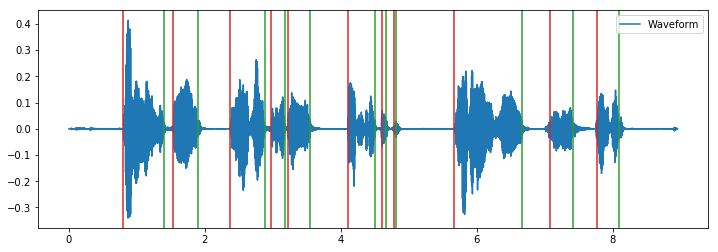

In [50]:
#Redraw the graph
plt.figure(figsize=(12, 4))
time = np.linspace(0, len(wave)/fs, len(wave))
plt.plot(time, wave, label='Waveform')
for s, e in zip(new_start, new_end):
    plt.axvline(x=s, color='#d62728') # red vertical line
    plt.axvline(x=e, color='#2ca02c') # green vertical line
plt.legend(loc='best')
plt.show()

### 8. Cut the original wave file into chunks corresponding the computed frame 

In [51]:
#Cut the original wave file into chunks corresponding the computed frame 
chunks = []
frame = []
inFrame = False
frame_idx = 0
num_frames = len(new_start)
time = np.linspace(0, len(wave)/fs, len(wave))
time = [(float("{0:.10f}".format(a))) for a in time]
for w,t in zip(wave,time):
    #if t is the beginning of a frame
    if t == new_start[frame_idx]:
        print("Start Frame!",t)
        #raise the inFrame flag, start collecting the wave
        inFrame = True
    #if t is the end of a frame
    elif t == new_end[frame_idx]:
        print("End Frame!",t)
        #collect the last value
        frame.append(w)
        #add the frame to the chunks
        chunks.append(frame)
        #reset the frame 
        frame = []
        #increment the frame index 
        frame_idx += 1
        #unflag the inFrame flag, stop collecting the wave
        inFrame = False
    #if t is somewhere in the frame, collect it
    if inFrame == True: 
        frame.append(w)
    #if no frame left to search for, break
    if frame_idx == num_frames:
        break
len(chunks)

Start Frame! 0.7980992813
End Frame! 1.3967417699
Start Frame! 1.5364250172
End Frame! 1.9055878851
Start Frame! 2.3745245011
End Frame! 2.8833706164
Start Frame! 2.9731669897
End Frame! 3.1826918607
Start Frame! 3.2226013599
End Frame! 3.5418773538
Start Frame! 4.1006103431
End Frame! 4.4997053355
Start Frame! 4.5994790836
End Frame! 4.6593433324
Start Frame! 4.7790718301
End Frame! 4.8090039545
Start Frame! 5.6670581881
End Frame! 6.664795669
Start Frame! 7.0738680362
End Frame! 7.413053428
Start Frame! 7.7622615463
End Frame! 8.091514915


11

### 8.5 If chunks has less than 1500 points, consider inaudible sound -> delete

In [52]:
chunks = [chunk for chunk in chunks if len(chunk) > 1500]

In [66]:
ipd.Audio(chunks[0]+chunks[2]+chunks[3]+chunks[5]+chunks[6], rate=fs)

### 9. CHECK THE CHUNKS 

In [54]:
#Mama's always
print("Num points:",len(chunks[0]))
ipd.Audio(chunks[0], rate=fs)

Num points: 13201


In [55]:
#Uhh
print("Num points:",len(chunks[1]))
ipd.Audio(chunks[1], rate=fs)

Num points: 8141


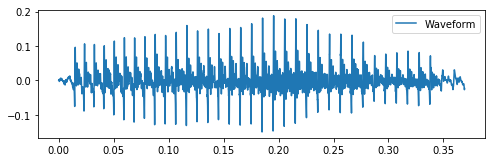

In [56]:
plt.figure(figsize=(8, 8))
plt.subplot(3, 1, 1)
t = np.linspace(0, len(chunks[1])/fs, len(chunks[1]))
plt.plot(t, chunks[1], label='Waveform')
plt.legend(loc='best')

In [57]:
#Said life
print("Num points:",len(chunks[2]))
ipd.Audio(chunks[2], rate=fs)

Num points: 11221


In [58]:
#is a
print("Num points:",len(chunks[3]))
ipd.Audio(chunks[3], rate=fs)

Num points: 4621


In [59]:
#uhh
print("Num points:",len(chunks[4]))
ipd.Audio(chunks[4], rate=fs)

Num points: 7041


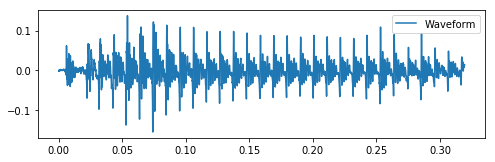

In [60]:
plt.figure(figsize=(8, 8))
plt.subplot(3, 1, 1)
t = np.linspace(0, len(chunks[4])/fs, len(chunks[4]))
plt.plot(t, chunks[4], label='Waveform')
plt.legend(loc='best')

In [61]:
#box
print("Num points:",len(chunks[5]))
ipd.Audio(chunks[5], rate=fs)

Num points: 8801


In [62]:
#Unknown
print("Num points:",len(chunks[6]))

ipd.Audio(chunks[6], rate=fs)

Num points: 22001


In [63]:
#Cho
print("Num points:",len(chunks[7]))
ipd.Audio(chunks[7], rate=fs)

Num points: 7480


In [64]:
#You never know what you're
print("Num points:",len(chunks[8]))

ipd.Audio(chunks[8], rate=fs)

Num points: 7261


In [65]:
#Uhh
print("Num points:",len(chunks[9]))
ipd.Audio(chunks[9], rate=fs)

IndexError: list index out of range

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(3, 1, 1)
t = np.linspace(0, len(chunks[9])/fs, len(chunks[9]))
plt.plot(t, chunks[9], label='Waveform')
plt.legend(loc='best')

In [ ]:
#Gonna
print("Num points:",len(chunks[10]))
ipd.Audio(chunks[10], rate=fs)

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(3, 1, 1)
t = np.linspace(0, len(chunks[10])/fs, len(chunks[10]))
plt.plot(t, chunks[10], label='Waveform')
plt.legend(loc='best')

In [ ]:
#Get
print("Num points:",len(chunks[11]))
ipd.Audio(chunks[11], rate=fs)

### 10. Writing chunks of points into text file

In [ ]:
#Writing chunks of points into text file 
#Format: 
#Frequency
#Number of chunks
#List of points of 1st chunk, separate by space
#List of points of 2nd chunk, separate by space...

out_filename = filename+"_chunks.txt"
file = open(out_filename,'w')
file.write(str(fs)+"\n")
file.write(str(len(chunks))+"\n")
for chunk in chunks:
    file.write(' '.join(str(w) for w in chunk))
    file.write('\n')
file.close()

In [ ]:
#PCA, feature extraction, try with large PCS ( like 200)